<a href="https://colab.research.google.com/github/sweonurulu/ensemble/blob/main/kolektif_ogrenme_final_proje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LOAD MODULS & GET DATASET

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
pip install faiss-gpu-cu12

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 18.7 MB/s eta 0:00:00


In [ ]:
pip install rank-bm25

In [ ]:
from sklearn.decomposition import PCA
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from transformers import AutoTokenizer
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss
import matplotlib.pyplot as plt
from collections import Counter

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
dataset = load_dataset("Metin/WikiRAG-TR")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.57k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/20.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5999 [00:00<?, ? examples/s]

In [ ]:
# Chunk ve soru ayrıştırma
chunks = []  # Tüm chunk'ları (metin parçalarını) saklamak için bir liste
correct_chunk_indices = []  # Doğru chunk'ların global indekslerini saklamak için bir liste
questions = []  # Soruları saklamak için bir liste

# Veri kümesinin 'train' bölümü üzerinde döngü
for i, example in enumerate(dataset['train']):
    # Her örnek için context, chunk'lara (\n ile ayrılmış metin parçalarına) bölünüyor
    question_chunks = example['context'].split("\n")
    correct_index = example['correct_intro_idx']  # Doğru chunk'ın indeksini al

    # Eğer chunk sayısı tam olarak 5 ise
    if len(question_chunks) == 5:
        # Tüm chunk'ları chunks listesine ekle
        chunks.extend(question_chunks)
        # Doğru chunk'ın global indeksini hesaplayıp kaydet
        correct_chunk_indices.append(len(questions) * 5 + correct_index)
        # Soruyu questions listesine ekle
        questions.append(example['question'])

    # Eğer chunk sayısı 6 ise (fazladan bir chunk varsa)
    elif len(question_chunks) == 6:
        # Eğer doğru chunk ilk 5 içinde yer alıyorsa, ilk 5 chunk'ı seç
        if correct_index < 5:
            selected_chunks = question_chunks[:5]
        # Eğer doğru chunk son chunk ise, ilk chunk'ı çıkar ve geri kalan 5'ini seç
        else:
            selected_chunks = question_chunks[1:]

        # Eğer doğru chunk seçilen chunk'lar arasında yoksa, son chunk'ı doğru chunk ile değiştir
        if question_chunks[correct_index] not in selected_chunks:
            selected_chunks[-1] = question_chunks[correct_index]

        # Seçilen chunk'ları chunks listesine ekle
        chunks.extend(selected_chunks)
        # Doğru chunk'ın seçilen chunk'lar arasındaki indeksini global indekse çevirip kaydet
        correct_chunk_indices.append(len(questions) * 5 + selected_chunks.index(question_chunks[correct_index]))
        # Soruyu questions listesine ekle
        questions.append(example['question'])

In [ ]:
# İlk 1000 soruyu seç
selected_questions = questions[:1000]

# İlk 5000 chunk'ı seç (her soru için 5 chunk)
selected_chunks = chunks[:5000]

# İlk 1000 doğru chunk indeksini seç
selected_correct_indices = correct_chunk_indices[:1000]

## EDA

In [ ]:
selected_questions[0]

"NKVD'nin Sovyetler Birliği içindeki siyasi baskı rolü nasıl işliyordu ve bu baskının sonuçları nelerdi?"

In [ ]:
selected_chunks[0:6]

["NKVD (Narodnıy komissariyat vnutrennnih del) (Rusça: НКВД, Народный комиссариат внутренних дел) veya İçişleri Halk Komiserliği, Sovyetler Birliği'nin çeşitli meselelerini idare eden devlet birimi. NKVD 1917'de kurulan ve başlangıçta düzenli polis çalışması yürütmek ve ülkenin hapishanelerini ve çalışma kamplarını denetlemekle görevli bir Sovyet kolluk kuvvetiydi. 1930'da dağıtıldı, ancak 1934'te tüm sendikaları kapsayan bir komiserlik olarak yeniden kuruldu. Bu süre zarfında NKVD, OGPU'nun (gizli bir polis örgütü) işlevlerini üstlendi ve hem düzenli polislik faaliyetlerinden hem de gizli polis faaliyetlerinden sorumlu oldu. Özellikle Joseph Stalin yönetimindeki Büyük Temizlik sırasında siyasi baskıdaki rolü ve yargısız infazlara, Gulag zorunlu çalışma kampları sistemine ve daha zengin köylülere yönelik baskıya dahil olmasıyla bilinir. Ayrıca Sovyet sınırlarının korunması, casusluk (siyasi suikastlar dahil) ve Polonya'daki baskı ve katliamlar da dahil olmak üzere diğer ülkelerde Sovye

In [ ]:
selected_correct_indices[0]

0

In [ ]:
len(selected_questions)

1000

In [ ]:
len(selected_chunks)

5000

In [ ]:
len(selected_correct_indices)

1000

## ÖDEV

In [ ]:
model_results = {}

### Word Matching

In [ ]:
# --- TF-IDF ---
vectorizer_word = TfidfVectorizer()
tfidf_matrix_word = vectorizer_word.fit_transform(selected_chunks)

def run_tfidf(vectorizer, tfidf_matrix, tokenization_method):
    all_indices = []
    top_1_correct = 0
    top_5_correct = 0
    for i, question in enumerate(selected_questions):
        query_vector = vectorizer.transform([tokenization_method(question)])
        scores = np.dot(tfidf_matrix, query_vector.T).toarray().flatten()
        indices = np.argsort(scores)[::-1][:5]
        all_indices.append(indices)

        if selected_correct_indices[i] in indices[:1]:
            top_1_correct += 1
        if selected_correct_indices[i] in indices:
            top_5_correct += 1

    return {
        "retrieved_indices": np.array(all_indices),
        "top_1_accuracy": top_1_correct / len(selected_questions),
        "top_5_accuracy": top_5_correct / len(selected_questions)
    }

# Word tokenization için TF-IDF sonuçları
model_results["tfidf_word"] = run_tfidf(vectorizer_word, tfidf_matrix_word, lambda x: x.lower())

# BERT tokenization için TF-IDF
bert_tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
def bert_tokenize(text):
    return " ".join(bert_tokenizer.tokenize(text.lower()))

tokenized_chunks_bert = [bert_tokenize(chunk) for chunk in selected_chunks]
vectorizer_bert = TfidfVectorizer()
tfidf_matrix_bert = vectorizer_bert.fit_transform(tokenized_chunks_bert)
model_results["tfidf_bert"] = run_tfidf(vectorizer_bert, tfidf_matrix_bert, bert_tokenize)

# --- BM25 ---
def run_bm25(tokenized_chunks, tokenization_method):
    bm25 = BM25Okapi(tokenized_chunks)
    all_indices = []
    top_1_correct = 0
    top_5_correct = 0
    for i, question in enumerate(selected_questions):
        tokenized_question = tokenization_method(question)
        scores = bm25.get_scores(tokenized_question)
        indices = np.argsort(scores)[::-1][:5]
        all_indices.append(indices)

        if selected_correct_indices[i] in indices[:1]:
            top_1_correct += 1
        if selected_correct_indices[i] in indices:
            top_5_correct += 1

    return {
        "retrieved_indices": np.array(all_indices),
        "top_1_accuracy": top_1_correct / len(selected_questions),
        "top_5_accuracy": top_5_correct / len(selected_questions)
    }

# Word tokenization için BM25 sonuçları
tokenized_chunks_word = [word_tokenize(chunk.lower()) for chunk in selected_chunks]
model_results["bm25_word"] = run_bm25(tokenized_chunks_word, lambda x: word_tokenize(x.lower()))

# BERT tokenization için BM25 sonuçları
tokenized_chunks_bert = [bert_tokenizer.tokenize(chunk.lower()) for chunk in selected_chunks]
model_results["bm25_bert"] = run_bm25(tokenized_chunks_bert, lambda x: bert_tokenizer.tokenize(x.lower()))

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# --- Sonuçları Yazdır ---
print("Sonuçlar:")
for method, results in model_results.items():
    print(f"\n{method.upper()}:")
    print(f"Top-1 Accuracy: {results['top_1_accuracy']:.2f}")
    print(f"Top-5 Accuracy: {results['top_5_accuracy']:.2f}")

Sonuçlar:

TFIDF_WORD:
Top-1 Accuracy: 0.28
Top-5 Accuracy: 0.46

TFIDF_BERT:
Top-1 Accuracy: 0.28
Top-5 Accuracy: 0.47

BM25_WORD:
Top-1 Accuracy: 0.22
Top-5 Accuracy: 0.40

BM25_BERT:
Top-1 Accuracy: 0.29
Top-5 Accuracy: 0.49


### Dense Modeller

In [ ]:
# Dense modeller
models = {
    "nomic-embed-text-v1": SentenceTransformer('nomic-ai/nomic-embed-text-v1', trust_remote_code=True),
    "instructor-large": SentenceTransformer('hkunlp/instructor-large'),
    "all-roberta-large-v1": SentenceTransformer('sentence-transformers/all-roberta-large-v1'),
    "jina-embedding-v3-m2v-1024": SentenceTransformer('Thaweewat/jina-embedding-v3-m2v-1024'),
    "bert-base-turkish-cased": SentenceTransformer('dbmdz/bert-base-turkish-cased'),
    "multilingual-e5-base": SentenceTransformer('intfloat/multilingual-e5-base'),
    "bge-m3": SentenceTransformer('BAAI/bge-m3'),
    #"snowflake-arctic-embed-l-v2.0": SentenceTransformer('Snowflake/snowflake-arctic-embed-l-v2.0'),
    #"e5-large-v2": SentenceTransformer('intfloat/e5-large-v2'),
    #"LaBSE": SentenceTransformer('sentence-transformers/LaBSE'),
}

# Modellerin embedding boyutlarını öğrenme
for model_name, model in models.items():
    embedding_dim = model.get_sentence_embedding_dimension()
    print(f"{model_name} modelinin embedding boyutu: {embedding_dim}")

target_dim = 768  # Ortak boyut

configuration_hf_nomic_bert.py:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nomic-ai/nomic-bert-2048:
- configuration_hf_nomic_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_hf_nomic_bert.py:   0%|          | 0.00/95.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nomic-ai/nomic-bert-2048:
- modeling_hf_nomic_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/547M [00:00<?, ?B/s]

/root/.cache/huggingface/modules/transformers_modules/nomic-ai/nomic-bert-2048/40b98394640e630d5276807046089b233113aa87/modeling_hf_nomic_bert.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this 

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.41k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.64k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/179k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

nomic-embed-text-v1 modelinin embedding boyutu: 768
instructor-large modelinin embedding boyutu: 768
all-roberta-large-v1 modelinin embedding boyutu: 1024
jina-embedding-v3-m2v-1024 modelinin embedding boyutu: 1024
bert-base-turkish-cased modelinin embedding boyutu: 768
multilingual-e5-base modelinin embedding boyutu: 768
bge-m3 modelinin embedding boyutu: 1024


In [ ]:
# Dense Modeller
for model_name, model in models.items():
    c_emb = model.encode(selected_chunks, convert_to_tensor=False, show_progress_bar=True)
    q_emb = model.encode(selected_questions, convert_to_tensor=False, show_progress_bar=True)

    # PCA uygulama
    pca = PCA(n_components=target_dim)
    c_emb = pca.fit_transform(c_emb)
    q_emb = pca.transform(q_emb)

    # FAISS index
    d = c_emb.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(c_emb)

    # Retrieval
    distances, retrieved_indices = index.search(np.array(q_emb), k=5)

    # Performans Ölçümü
    top_1_correct = 0
    top_5_correct = 0
    for i, indices in enumerate(retrieved_indices):
        if selected_correct_indices[i] in indices[:1]:
            top_1_correct += 1
        if selected_correct_indices[i] in indices:
            top_5_correct += 1

    model_results[model_name] = {
        "retrieved_indices": retrieved_indices,
        "top_1_accuracy": top_1_correct / len(selected_questions),
        "top_5_accuracy": top_5_correct / len(selected_questions)
    }

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

### Tekil Sonuçlar

In [ ]:
# Tekil yöntem sonuçları
for model_name, results in model_results.items():
    print(f"{model_name} - Top-1 Accuracy: {results['top_1_accuracy']:.4f}, Top-5 Accuracy: {results['top_5_accuracy']:.4f}")

tfidf_word - Top-1 Accuracy: 0.2750, Top-5 Accuracy: 0.4570
tfidf_bert - Top-1 Accuracy: 0.2760, Top-5 Accuracy: 0.4740
bm25_word - Top-1 Accuracy: 0.2190, Top-5 Accuracy: 0.4020
bm25_bert - Top-1 Accuracy: 0.2910, Top-5 Accuracy: 0.4940
nomic-embed-text-v1 - Top-1 Accuracy: 0.2610, Top-5 Accuracy: 0.4160
instructor-large - Top-1 Accuracy: 0.2290, Top-5 Accuracy: 0.3890
all-roberta-large-v1 - Top-1 Accuracy: 0.1970, Top-5 Accuracy: 0.3380
jina-embedding-v3-m2v-1024 - Top-1 Accuracy: 0.1540, Top-5 Accuracy: 0.2670
bert-base-turkish-cased - Top-1 Accuracy: 0.1520, Top-5 Accuracy: 0.2960
multilingual-e5-base - Top-1 Accuracy: 0.3390, Top-5 Accuracy: 0.5310
bge-m3 - Top-1 Accuracy: 0.3330, Top-5 Accuracy: 0.5350


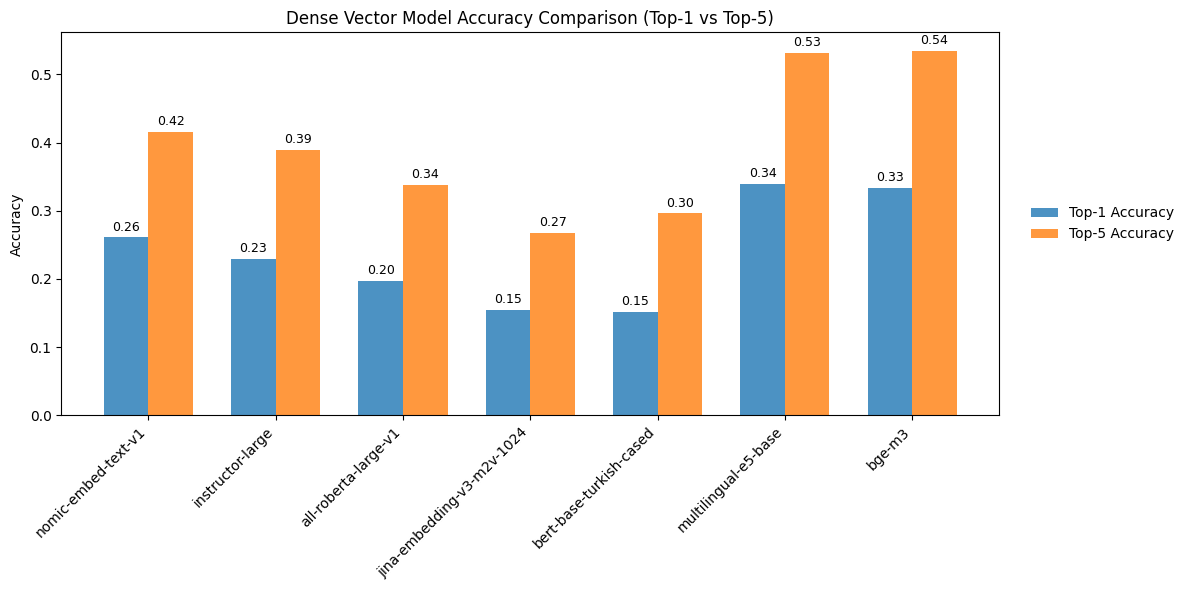

In [ ]:
# Dense modelleri filtreleme
dense_models = ["nomic-embed-text-v1","instructor-large", "all-roberta-large-v1", "jina-embedding-v3-m2v-1024",
                "bert-base-turkish-cased", "multilingual-e5-base", "bge-m3"]
dense_top_1_accuracies = [model_results[model]["top_1_accuracy"] for model in dense_models]
dense_top_5_accuracies = [model_results[model]["top_5_accuracy"] for model in dense_models]

x = np.arange(len(dense_models))  # Dense modeller için x ekseni

# Çubuk grafik
plt.figure(figsize=(12, 6))
bar_width = 0.35  # Çubuk genişliği
plt.bar(x - bar_width / 2, dense_top_1_accuracies, width=bar_width, label="Top-1 Accuracy", alpha=0.8)
plt.bar(x + bar_width / 2, dense_top_5_accuracies, width=bar_width, label="Top-5 Accuracy", alpha=0.8)

# Grafik detayları
plt.xticks(x, dense_models, rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Dense Vector Model Accuracy Comparison (Top-1 vs Top-5)")

# Legend'i sağ tarafa taşıma
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

plt.tight_layout()

# Skorları çubukların üzerine yazma
for i, v in enumerate(dense_top_1_accuracies):
    plt.text(x[i] - bar_width / 2, v + 0.01, f"{v:.2f}", ha='center', fontsize=9)

for i, v in enumerate(dense_top_5_accuracies):
    plt.text(x[i] + bar_width / 2, v + 0.01, f"{v:.2f}", ha='center', fontsize=9)

plt.show()

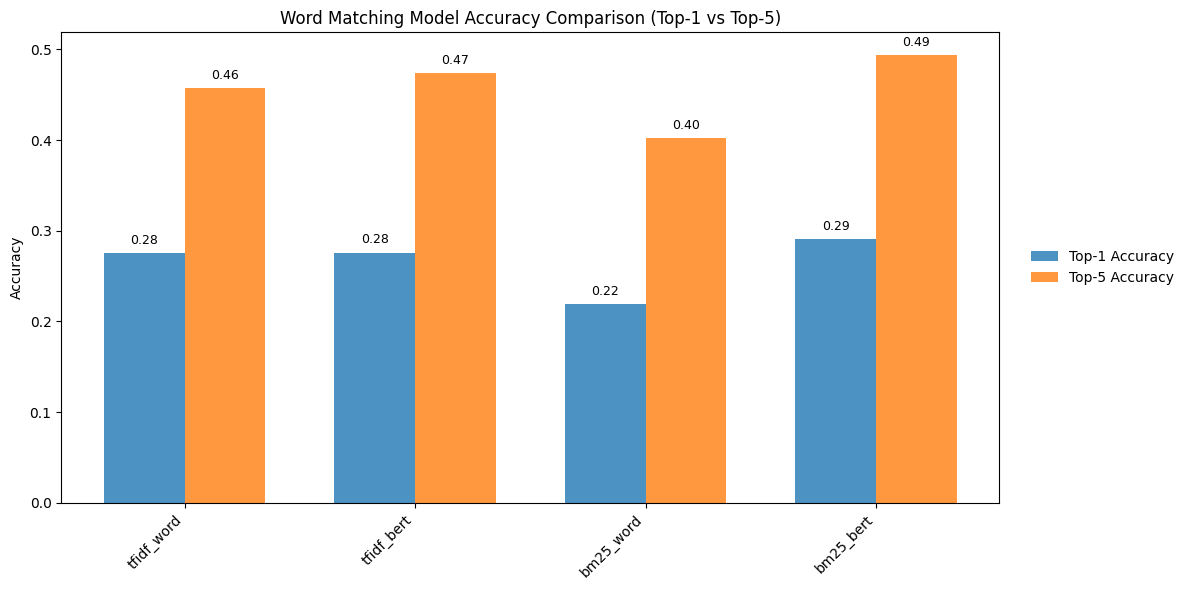

In [ ]:
# Word matching modelleri filtreleme
word_models = ["tfidf_word", "tfidf_bert", "bm25_word", "bm25_bert"]
word_top_1_accuracies = [model_results[model]["top_1_accuracy"] for model in word_models]
word_top_5_accuracies = [model_results[model]["top_5_accuracy"] for model in word_models]

x = np.arange(len(word_models))  # Word matching modeller için x ekseni

# Çubuk grafik
plt.figure(figsize=(12, 6))
bar_width = 0.35  # Çubuk genişliği
plt.bar(x - bar_width / 2, word_top_1_accuracies, width=bar_width, label="Top-1 Accuracy", alpha=0.8)
plt.bar(x + bar_width / 2, word_top_5_accuracies, width=bar_width, label="Top-5 Accuracy", alpha=0.8)

# Grafik detayları
plt.xticks(x, word_models, rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Word Matching Model Accuracy Comparison (Top-1 vs Top-5)")

# Legend'i sağ tarafa taşıma
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

plt.tight_layout()

# Skorları çubukların üzerine yazma
for i, v in enumerate(word_top_1_accuracies):
    plt.text(x[i] - bar_width / 2, v + 0.01, f"{v:.2f}", ha='center', fontsize=9)

for i, v in enumerate(word_top_5_accuracies):
    plt.text(x[i] + bar_width / 2, v + 0.01, f"{v:.2f}", ha='center', fontsize=9)

plt.show()

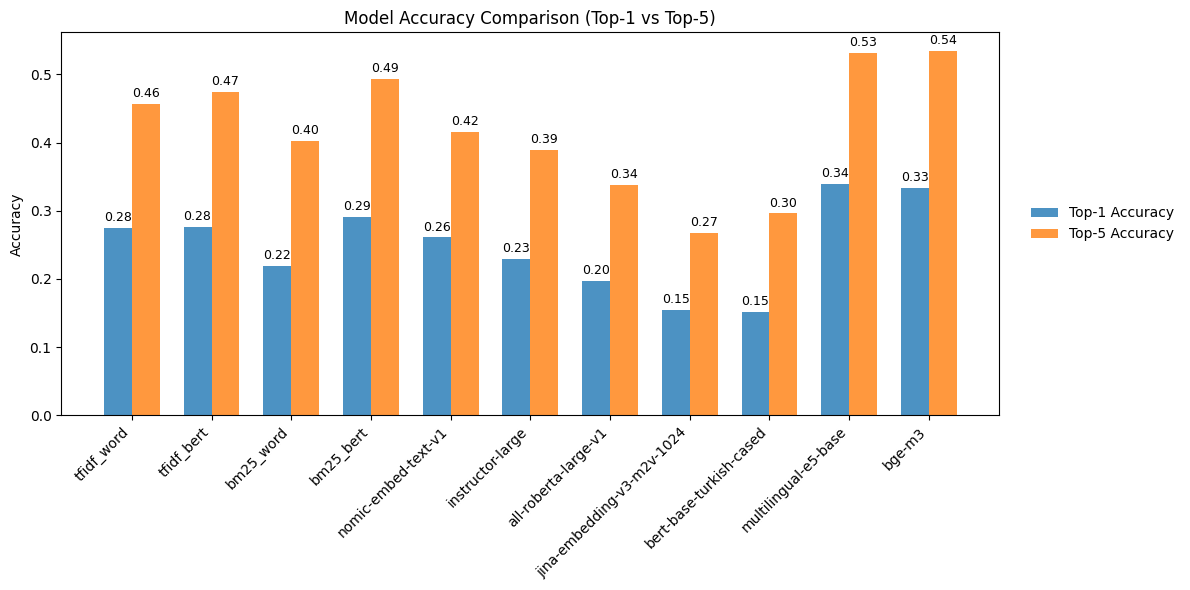

In [ ]:
# Sonuçları görselleştirme
model_names = list(model_results.keys())
top_1_accuracies = [model_results[model]["top_1_accuracy"] for model in model_names]
top_5_accuracies = [model_results[model]["top_5_accuracy"] for model in model_names]

x = np.arange(len(model_names))  # Model sayısına göre x ekseni

# Çubuk grafik
plt.figure(figsize=(12, 6))
bar_width = 0.35  # Çubuk genişliği
plt.bar(x - bar_width / 2, top_1_accuracies, width=bar_width, label="Top-1 Accuracy", alpha=0.8)
plt.bar(x + bar_width / 2, top_5_accuracies, width=bar_width, label="Top-5 Accuracy", alpha=0.8)

# Grafik detayları
plt.xticks(x, model_names, rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison (Top-1 vs Top-5)")

# Legend'i sağ tarafa taşıma
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

plt.tight_layout()

# Skorları çubukların üzerine yazma
for i, v in enumerate(top_1_accuracies):
    plt.text(x[i] - bar_width / 2, v + 0.01, f"{v:.2f}", ha='center', fontsize=9)

for i, v in enumerate(top_5_accuracies):
    plt.text(x[i] + bar_width / 2, v + 0.01, f"{v:.2f}", ha='center', fontsize=9)

plt.show()

### Ensemble Yöntemler

In [ ]:
def majority_vote_ensemble(model_results, selected_correct_indices, top_k=5):
    """
    Majority vote ensemble yöntemiyle retrieval sonuçlarını birleştirir ve doğruluk oranlarını hesaplar.

    Args:
        model_results (dict): Modellerin retrieval sonuçlarını içeren sözlük.
                              Her model için "retrieved_indices" ve doğruluklar bulunur.
        selected_correct_indices (list): Doğru chunk'ların indekslerini içeren liste.
        top_k (int): İlk k tahmin üzerinden ensemble işlemi yapılır (default: 5).

    Returns:
        dict: Ensemble sonuçları, Top-1 ve Top-5 doğruluk oranlarını içerir.
    """
    ensemble_indices = []  # Her soru için ensemble sonucundaki tahminlerin indekslerini tutar
    top_1_correct = 0  # Top-1 doğruluk sayacı
    top_5_correct = 0  # Top-5 doğruluk sayacı

    # Her soru için tahminleri birleştir
    for question_idx in range(len(selected_correct_indices)):
        all_predictions = []  # Tüm modellerin tahminlerini toplamak için liste

        # Tüm modellerin tahminlerini al
        for model_name, results in model_results.items():
            # Her model için top_k tahminleri alınır
            all_predictions.extend(results["retrieved_indices"][question_idx][:top_k])

        # Majority vote (en çok oy alan) hesapla
        vote_counts = Counter(all_predictions)  # Chunk indekslerini ve oy sayılarını sayar
        top_k_ensemble = [item[0] for item in vote_counts.most_common(top_k)]  # İlk k tahmin
        ensemble_indices.append(top_k_ensemble)  # Ensemble sonuçlarına ekle

        # Doğruluk hesapla
        # Top-1: İlk tahminde doğru chunk var mı?
        if selected_correct_indices[question_idx] in top_k_ensemble[:1]:
            top_1_correct += 1
        # Top-5: İlk 5 tahminde doğru chunk var mı?
        if selected_correct_indices[question_idx] in top_k_ensemble:
            top_5_correct += 1

    # Toplam doğruluk oranları
    return {
        "retrieved_indices": np.array(ensemble_indices),  # Ensemble tahmin indeksleri
        "top_1_accuracy": top_1_correct / len(selected_correct_indices),  # Top-1 doğruluk oranı
        "top_5_accuracy": top_5_correct / len(selected_correct_indices)   # Top-5 doğruluk oranı
    }

In [ ]:
def weighted_vote_ensemble(model_results, selected_correct_indices, top_k=5):
    """
    Weighted vote ensemble yöntemiyle retrieval sonuçlarını birleştirir ve doğruluk oranlarını hesaplar.
    Modellerin Top-1 ve Top-5 doğruluklarına göre ağırlıklandırılmış oylama yapılır.

    Args:
        model_results (dict): Modellerin retrieval sonuçlarını içeren sözlük.
                              Her model için "retrieved_indices" ve doğruluklar bulunur.
        selected_correct_indices (list): Doğru chunk'ların indekslerini içeren liste.
        top_k (int): İlk k tahmin üzerinden ensemble işlemi yapılır (default: 5).

    Returns:
        dict: Ensemble sonuçları, Top-1 ve Top-5 doğruluk oranlarını içerir.
    """
    ensemble_indices = []  # Her soru için ensemble sonucundaki tahminlerin indekslerini tutar
    top_1_correct = 0  # Top-1 doğruluk sayacı
    top_5_correct = 0  # Top-5 doğruluk sayacı

    # Model ağırlıkları hesaplanıyor (Top-1 için ayrı, Top-5 için ayrı ağırlıklar)
    top_1_weights = {
        model_name: results["top_1_accuracy"] / sum(
            result["top_1_accuracy"] for result in model_results.values()
        )
        for model_name, results in model_results.items()
    }
    print("Top-1 ağırlıkları:", top_1_weights)

    top_5_weights = {
        model_name: results["top_5_accuracy"] / sum(
            result["top_5_accuracy"] for result in model_results.values()
        )
        for model_name, results in model_results.items()
    }
    print("Top-5 ağırlıkları:", top_5_weights)

    # Her soru için tahminleri birleştir
    for question_idx in range(len(selected_correct_indices)):
        weighted_scores_top_1 = Counter()  # Top-1 ağırlıklarıyla hesaplanan skorlar
        weighted_scores_top_5 = Counter()  # Top-5 ağırlıklarıyla hesaplanan skorlar

        # Her modelden gelen tahminlere ağırlık uygula
        for model_name, results in model_results.items():
            retrieved_indices = results["retrieved_indices"][question_idx][:top_k]  # İlk k tahmini al
            for rank, index in enumerate(retrieved_indices):
                # Top-1 için ağırlıklandırma
                weighted_scores_top_1[index] += top_1_weights[model_name] * (top_k - rank)

                # Top-5 için ağırlıklandırma
                weighted_scores_top_5[index] += top_5_weights[model_name] * (top_k - rank)

        # En çok oy alanları seç (ilk k tahmin)
        top_k_ensemble_top_1 = [item[0] for item in weighted_scores_top_1.most_common(top_k)]
        top_k_ensemble_top_5 = [item[0] for item in weighted_scores_top_5.most_common(top_k)]
        ensemble_indices.append((top_k_ensemble_top_1, top_k_ensemble_top_5))

        # Top-1 doğruluk hesapla
        if selected_correct_indices[question_idx] in top_k_ensemble_top_1[:1]:  # İlk tahminde doğru chunk var mı?
            top_1_correct += 1

        # Top-5 doğruluk hesapla
        if selected_correct_indices[question_idx] in top_k_ensemble_top_5:  # İlk 5 tahminde doğru chunk var mı?
            top_5_correct += 1

    # Toplam doğruluk oranları
    return {
        "retrieved_indices": np.array(ensemble_indices),  # Ensemble tahmin indeksleri
        "top_1_accuracy": top_1_correct / len(selected_correct_indices),  # Top-1 doğruluk oranı
        "top_5_accuracy": top_5_correct / len(selected_correct_indices),  # Top-5 doğruluk oranı
    }

In [ ]:
def equal_weight_ensemble(model_results, selected_correct_indices, top_k=5):
    """
    Equal weight ensemble yöntemiyle retrieval sonuçlarını birleştirir ve doğruluk oranlarını hesaplar.
    Tüm modellere eşit ağırlık verilerek tahminler birleştirilir.

    Args:
        model_results (dict): Modellerin retrieval sonuçlarını içeren sözlük.
                              Her model için "retrieved_indices" ve doğruluklar bulunur.
        selected_correct_indices (list): Doğru chunk'ların indekslerini içeren liste.
        top_k (int): İlk k tahmin üzerinden ensemble işlemi yapılır (default: 5).

    Returns:
        dict: Ensemble sonuçları, Top-1 ve Top-5 doğruluk oranlarını içerir.
    """
    ensemble_indices = []  # Her soru için ensemble sonucundaki tahminlerin indekslerini tutar
    top_1_correct = 0  # Top-1 doğruluk sayacı
    top_5_correct = 0  # Top-5 doğruluk sayacı

    # Her soru için tahminleri birleştir
    for question_idx in range(len(selected_correct_indices)):
        vote_counts = Counter()  # Tüm modellerden gelen tahminlerin oy sayısını tutar

        # Her modelin tahminlerine eşit ağırlık ver
        for model_name, results in model_results.items():
            retrieved_indices = results["retrieved_indices"][question_idx][:top_k]  # İlk k tahmini al
            for rank, index in enumerate(retrieved_indices):
                # Tahmin edilen her chunk'a eşit ağırlık verilir, rank'e göre azalan ağırlık eklenebilir
                vote_counts[index] += (top_k - rank)

        # En çok oy alanları seç (ilk k tahmin)
        top_k_ensemble = [item[0] for item in vote_counts.most_common(top_k)]
        ensemble_indices.append(top_k_ensemble)

        # Top-1 doğruluk hesapla
        if selected_correct_indices[question_idx] in top_k_ensemble[:1]:  # İlk tahminde doğru chunk var mı?
            top_1_correct += 1

        # Top-5 doğruluk hesapla
        if selected_correct_indices[question_idx] in top_k_ensemble:  # İlk 5 tahminde doğru chunk var mı?
            top_5_correct += 1

    # Toplam doğruluk oranları
    return {
        "retrieved_indices": np.array(ensemble_indices),  # Ensemble tahmin indeksleri
        "top_1_accuracy": top_1_correct / len(selected_correct_indices),  # Top-1 doğruluk oranı
        "top_5_accuracy": top_5_correct / len(selected_correct_indices),  # Top-5 doğruluk oranı
    }

In [ ]:
# Equal weight ensemble sonuçlarını hesapla
equal_weight_results = equal_weight_ensemble(model_results, selected_correct_indices, top_k=5)

# Sonuçları yazdır
print(f"Equal Weight Ensemble - Top-1 Accuracy: {equal_weight_results['top_1_accuracy']:.4f}")
print(f"Equal Weight Ensemble - Top-5 Accuracy: {equal_weight_results['top_5_accuracy']:.4f}")

# Weighted ensemble sonuçlarını hesapla
weighted_ensemble_results = weighted_vote_ensemble(model_results, selected_correct_indices, top_k=5)

# Sonuçları yazdır
print(f"Weighted Vote Ensemble - Top-1 Accuracy: {weighted_ensemble_results['top_1_accuracy']:.4f}")
print(f"Weighted Vote Ensemble - Top-5 Accuracy: {weighted_ensemble_results['top_5_accuracy']:.4f}")

# Majority vote ensemble sonuçlarını hesapla
ensemble_results = majority_vote_ensemble(model_results, selected_correct_indices, top_k=5)

# Sonuçları yazdır
print(f"Majority Vote Ensemble - Top-1 Accuracy: {ensemble_results['top_1_accuracy']:.4f}")
print(f"Majority Vote Ensemble - Top-5 Accuracy: {ensemble_results['top_5_accuracy']:.4f}")

Equal Weight Ensemble - Top-1 Accuracy: 0.3200
Equal Weight Ensemble - Top-5 Accuracy: 0.5340
{'tfidf_word': 0.10088041085840058, 'tfidf_bert': 0.1012472487160675, 'bm25_word': 0.08033749082905355, 'bm25_bert': 0.10674981658107115, 'nomic-embed-text-v1': 0.09574468085106382, 'instructor-large': 0.08400586940572266, 'all-roberta-large-v1': 0.0722670579603815, 'jina-embedding-v3-m2v-1024': 0.05649303008070432, 'bert-base-turkish-cased': 0.055759354365370495, 'multilingual-e5-base': 0.1243580337490829, 'bge-m3': 0.12215700660308143}
{'tfidf_word': 0.09936942813655142, 'tfidf_bert': 0.10306588388780169, 'bm25_word': 0.08741030658838878, 'bm25_bert': 0.10741465535986083, 'nomic-embed-text-v1': 0.09045444661883018, 'instructor-large': 0.08458360513155033, 'all-roberta-large-v1': 0.07349423787779952, 'jina-embedding-v3-m2v-1024': 0.05805609915198957, 'bert-base-turkish-cased': 0.06436181778647532, 'multilingual-e5-base': 0.11545988258317026, 'bge-m3': 0.11632963687758209}
Weighted Vote Ensemb

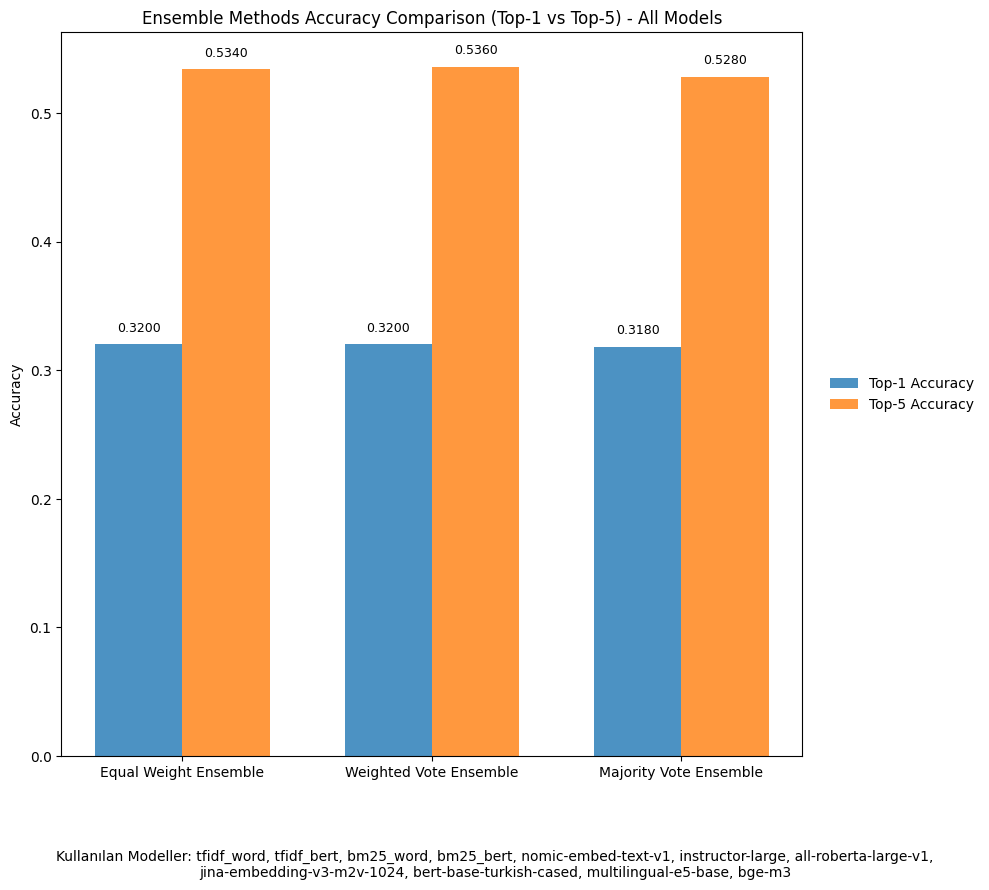

In [ ]:
# Ensemble yöntemleri ve doğruluk sonuçları
ensemble_methods = ["Equal Weight Ensemble", "Weighted Vote Ensemble", "Majority Vote Ensemble"]
top_1_accuracies = [
    equal_weight_results["top_1_accuracy"],
    weighted_ensemble_results["top_1_accuracy"],
    ensemble_results["top_1_accuracy"]
]
top_5_accuracies = [
    equal_weight_results["top_5_accuracy"],
    weighted_ensemble_results["top_5_accuracy"],
    ensemble_results["top_5_accuracy"]
]

# Model isimlerini model_results'tan dinamik olarak çek
used_models = list(model_results.keys())

# Çubuk grafik
x = np.arange(len(ensemble_methods))  # Ensemble yöntemleri için x ekseni

plt.figure(figsize=(10, 8))  # Yükseklik biraz artırıldı
bar_width = 0.35  # Çubuk genişliği
plt.bar(x - bar_width / 2, top_1_accuracies, width=bar_width, label="Top-1 Accuracy", alpha=0.8)
plt.bar(x + bar_width / 2, top_5_accuracies, width=bar_width, label="Top-5 Accuracy", alpha=0.8)

# Grafik detayları
plt.xticks(x, ensemble_methods, rotation=0, ha='center')
plt.ylabel("Accuracy")
plt.title("Ensemble Methods Accuracy Comparison (Top-1 vs Top-5) - All Models")

# Legend'i sağ tarafa taşıma
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

# Alt kısma kullanılan modelleri yazdırma
model_text = "Kullanılan Modeller: " + ", ".join(used_models)
plt.figtext(0.5, -0.1, model_text, wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()

# Skorları çubukların üzerine yazma
for i, v in enumerate(top_1_accuracies):
    plt.text(x[i] - bar_width / 2, v + 0.01, f"{v:.4f}", ha='center', fontsize=9)

for i, v in enumerate(top_5_accuracies):
    plt.text(x[i] + bar_width / 2, v + 0.01, f"{v:.4f}", ha='center', fontsize=9)

plt.show()

In [ ]:
# Kullanılacak modelleri filtrele
filtered_model_results = {
    model_name: model_results[model_name]
    for model_name in ["bm25_word", "bm25_bert", "nomic-embed-text-v1", "multilingual-e5-base", "bge-m3"]
}

# Equal weight ensemble sonuçlarını hesapla (sadece filtrelenmiş modellerle)
equal_weight_results_filtered = equal_weight_ensemble(filtered_model_results, selected_correct_indices, top_k=5)
print(f"Equal Weight Ensemble (Filtered) - Top-1 Accuracy: {equal_weight_results_filtered['top_1_accuracy']:.4f}")
print(f"Equal Weight Ensemble (Filtered) - Top-5 Accuracy: {equal_weight_results_filtered['top_5_accuracy']:.4f}")

# Weighted vote ensemble sonuçlarını hesapla (sadece filtrelenmiş modellerle)
weighted_ensemble_results_filtered = weighted_vote_ensemble(filtered_model_results, selected_correct_indices, top_k=5)
print(f"Weighted Vote Ensemble (Filtered) - Top-1 Accuracy: {weighted_ensemble_results_filtered['top_1_accuracy']:.4f}")
print(f"Weighted Vote Ensemble (Filtered) - Top-5 Accuracy: {weighted_ensemble_results_filtered['top_5_accuracy']:.4f}")

# Majority vote ensemble sonuçlarını hesapla (sadece filtrelenmiş modellerle)
majority_ensemble_results_filtered = majority_vote_ensemble(filtered_model_results, selected_correct_indices, top_k=5)
print(f"Majority Vote Ensemble (Filtered) - Top-1 Accuracy: {majority_ensemble_results_filtered['top_1_accuracy']:.4f}")
print(f"Majority Vote Ensemble (Filtered) - Top-5 Accuracy: {majority_ensemble_results_filtered['top_5_accuracy']:.4f}")

Equal Weight Ensemble (Filtered) - Top-1 Accuracy: 0.3230
Equal Weight Ensemble (Filtered) - Top-5 Accuracy: 0.5350
Top-1 ağırlıkları: {'bm25_word': 0.15176715176715175, 'bm25_bert': 0.20166320166320165, 'nomic-embed-text-v1': 0.18087318087318088, 'multilingual-e5-base': 0.23492723492723494, 'bge-m3': 0.23076923076923078}
Top-5 ağırlıkları: {'bm25_word': 0.16904962153069808, 'bm25_bert': 0.20773759461732547, 'nomic-embed-text-v1': 0.17493692178301093, 'multilingual-e5-base': 0.2232968881412952, 'bge-m3': 0.2249789739276703}
Weighted Vote Ensemble (Filtered) - Top-1 Accuracy: 0.3360
Weighted Vote Ensemble (Filtered) - Top-5 Accuracy: 0.5350
Majority Vote Ensemble (Filtered) - Top-1 Accuracy: 0.3120
Majority Vote Ensemble (Filtered) - Top-5 Accuracy: 0.5280


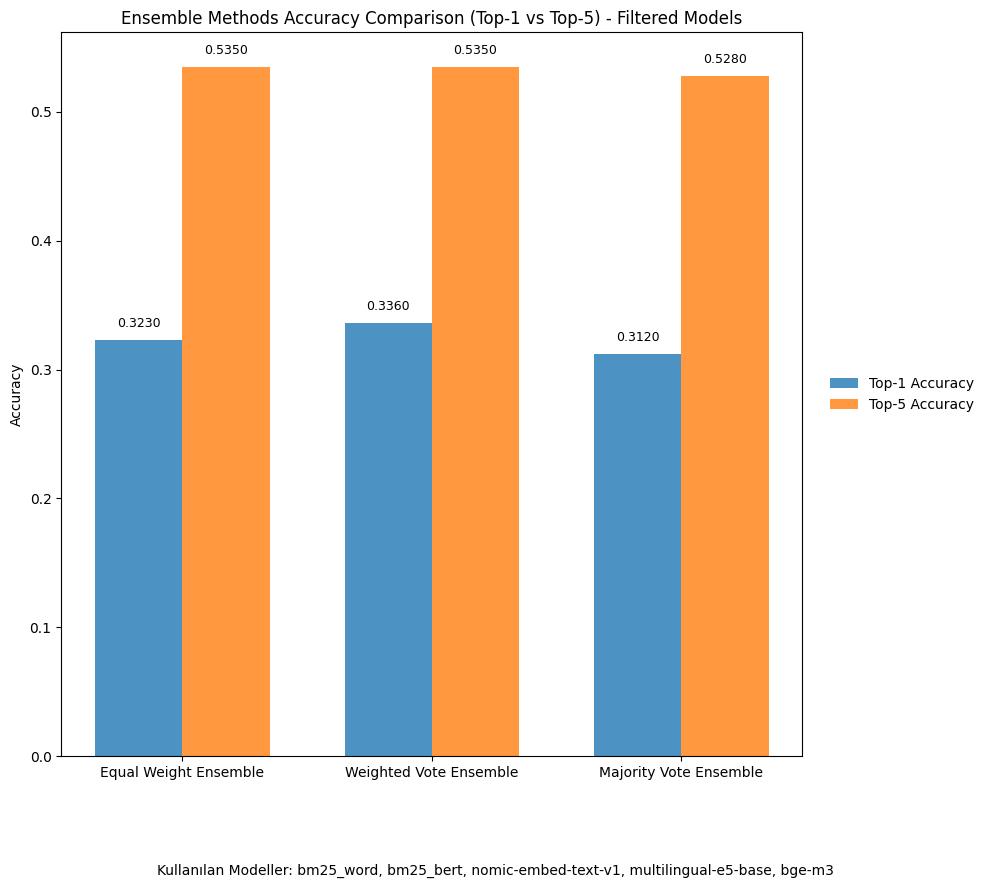

In [ ]:
# Ensemble yöntemleri ve doğruluk sonuçları
ensemble_methods = ["Equal Weight Ensemble", "Weighted Vote Ensemble", "Majority Vote Ensemble"]
top_1_accuracies = [
    equal_weight_results_filtered["top_1_accuracy"],
    weighted_ensemble_results_filtered["top_1_accuracy"],
    majority_ensemble_results_filtered["top_1_accuracy"]
]
top_5_accuracies = [
    equal_weight_results_filtered["top_5_accuracy"],
    weighted_ensemble_results_filtered["top_5_accuracy"],
    majority_ensemble_results_filtered["top_5_accuracy"]
]

# Filtrelenmiş modellerin isimleri
filtered_models = ["bm25_word", "bm25_bert", "nomic-embed-text-v1", "multilingual-e5-base", "bge-m3"]

# Çubuk grafik
x = np.arange(len(ensemble_methods))  # Ensemble yöntemleri için x ekseni

plt.figure(figsize=(10, 8))  # Grafik boyutları
bar_width = 0.35  # Çubuk genişliği
plt.bar(x - bar_width / 2, top_1_accuracies, width=bar_width, label="Top-1 Accuracy", alpha=0.8)
plt.bar(x + bar_width / 2, top_5_accuracies, width=bar_width, label="Top-5 Accuracy", alpha=0.8)

# Grafik detayları
plt.xticks(x, ensemble_methods, rotation=0, ha='center')
plt.ylabel("Accuracy")
plt.title("Ensemble Methods Accuracy Comparison (Top-1 vs Top-5) - Filtered Models")

# Legend'i sağ tarafa taşıma
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

# Alt kısma kullanılan modelleri yazdırma
model_text = "Kullanılan Modeller: " + ", ".join(filtered_models)
plt.figtext(0.5, -0.1, model_text, wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()

# Skorları çubukların üzerine yazma
for i, v in enumerate(top_1_accuracies):
    plt.text(x[i] - bar_width / 2, v + 0.01, f"{v:.4f}", ha='center', fontsize=9)

for i, v in enumerate(top_5_accuracies):
    plt.text(x[i] + bar_width / 2, v + 0.01, f"{v:.4f}", ha='center', fontsize=9)

plt.show()

In [ ]:
# Kullanılacak modelleri filtrele
filtered_model_results = {
    model_name: model_results[model_name]
    for model_name in ["bm25_word", "bm25_bert", "tfidf_bert", "multilingual-e5-base", "bge-m3"]
}

# Equal weight ensemble sonuçlarını hesapla (sadece filtrelenmiş modellerle)
equal_weight_results_filtered = equal_weight_ensemble(filtered_model_results, selected_correct_indices, top_k=5)
print(f"Equal Weight Ensemble (Filtered) - Top-1 Accuracy: {equal_weight_results_filtered['top_1_accuracy']:.4f}")
print(f"Equal Weight Ensemble (Filtered) - Top-5 Accuracy: {equal_weight_results_filtered['top_5_accuracy']:.4f}")

# Weighted vote ensemble sonuçlarını hesapla (sadece filtrelenmiş modellerle)
weighted_ensemble_results_filtered = weighted_vote_ensemble(filtered_model_results, selected_correct_indices, top_k=5)
print(f"Weighted Vote Ensemble (Filtered) - Top-1 Accuracy: {weighted_ensemble_results_filtered['top_1_accuracy']:.4f}")
print(f"Weighted Vote Ensemble (Filtered) - Top-5 Accuracy: {weighted_ensemble_results_filtered['top_5_accuracy']:.4f}")

# Majority vote ensemble sonuçlarını hesapla (sadece filtrelenmiş modellerle)
majority_ensemble_results_filtered = majority_vote_ensemble(filtered_model_results, selected_correct_indices, top_k=5)
print(f"Majority Vote Ensemble (Filtered) - Top-1 Accuracy: {majority_ensemble_results_filtered['top_1_accuracy']:.4f}")
print(f"Majority Vote Ensemble (Filtered) - Top-5 Accuracy: {majority_ensemble_results_filtered['top_5_accuracy']:.4f}")

Equal Weight Ensemble (Filtered) - Top-1 Accuracy: 0.3250
Equal Weight Ensemble (Filtered) - Top-5 Accuracy: 0.5340
Top-1 ağırlıkları: {'bm25_word': 0.15020576131687244, 'bm25_bert': 0.19958847736625512, 'tfidf_bert': 0.18930041152263377, 'multilingual-e5-base': 0.23251028806584365, 'bge-m3': 0.22839506172839508}
Top-5 ağırlıkları: {'bm25_word': 0.16502463054187191, 'bm25_bert': 0.20279146141215104, 'tfidf_bert': 0.1945812807881773, 'multilingual-e5-base': 0.21798029556650245, 'bge-m3': 0.2196223316912972}
Weighted Vote Ensemble (Filtered) - Top-1 Accuracy: 0.3340
Weighted Vote Ensemble (Filtered) - Top-5 Accuracy: 0.5380
Majority Vote Ensemble (Filtered) - Top-1 Accuracy: 0.3000
Majority Vote Ensemble (Filtered) - Top-5 Accuracy: 0.5210


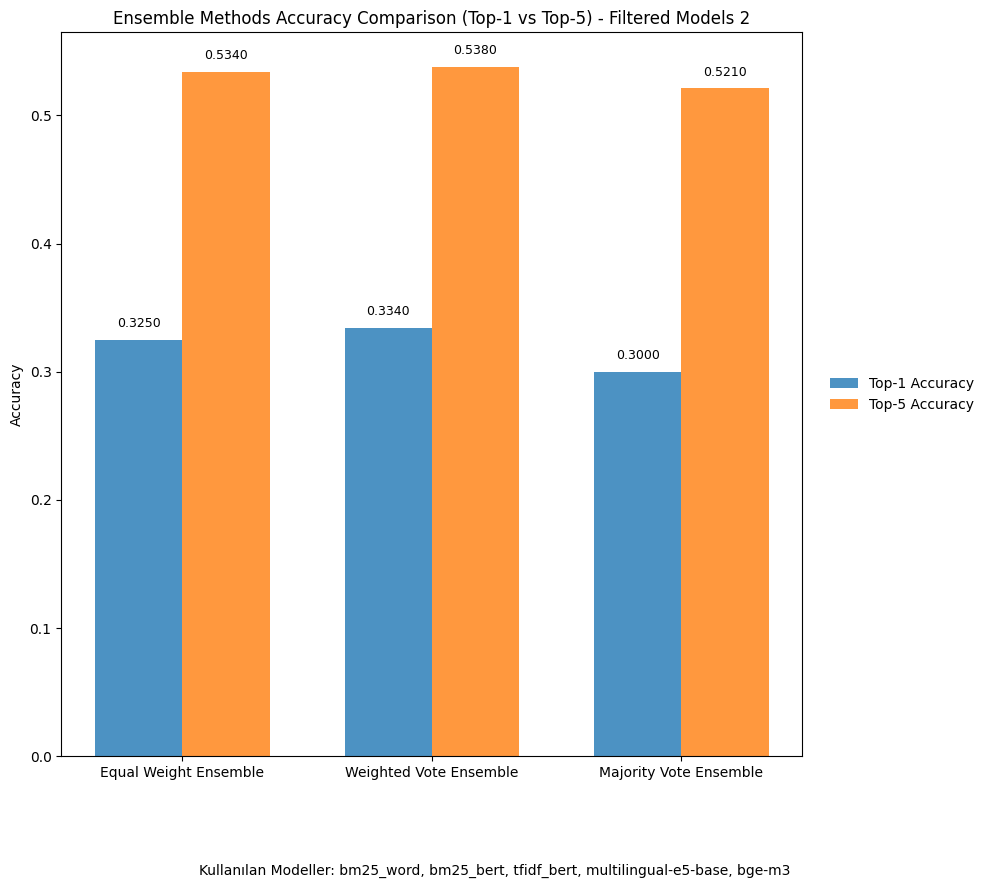

In [ ]:
# Ensemble yöntemleri ve doğruluk sonuçları
ensemble_methods = ["Equal Weight Ensemble", "Weighted Vote Ensemble", "Majority Vote Ensemble"]
top_1_accuracies = [
    equal_weight_results_filtered["top_1_accuracy"],
    weighted_ensemble_results_filtered["top_1_accuracy"],
    majority_ensemble_results_filtered["top_1_accuracy"]
]
top_5_accuracies = [
    equal_weight_results_filtered["top_5_accuracy"],
    weighted_ensemble_results_filtered["top_5_accuracy"],
    majority_ensemble_results_filtered["top_5_accuracy"]
]

# Filtrelenmiş modellerin isimleri
filtered_models = ["bm25_word", "bm25_bert", "tfidf_bert", "multilingual-e5-base", "bge-m3"]

# Çubuk grafik
x = np.arange(len(ensemble_methods))  # Ensemble yöntemleri için x ekseni

plt.figure(figsize=(10, 8))  # Grafik boyutları
bar_width = 0.35  # Çubuk genişliği
plt.bar(x - bar_width / 2, top_1_accuracies, width=bar_width, label="Top-1 Accuracy", alpha=0.8)
plt.bar(x + bar_width / 2, top_5_accuracies, width=bar_width, label="Top-5 Accuracy", alpha=0.8)

# Grafik detayları
plt.xticks(x, ensemble_methods, rotation=0, ha='center')
plt.ylabel("Accuracy")
plt.title("Ensemble Methods Accuracy Comparison (Top-1 vs Top-5) - Filtered Models 2")

# Legend'i sağ tarafa taşıma
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

# Alt kısma kullanılan modelleri yazdırma
model_text = "Kullanılan Modeller: " + ", ".join(filtered_models)
plt.figtext(0.5, -0.1, model_text, wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()

# Skorları çubukların üzerine yazma
for i, v in enumerate(top_1_accuracies):
    plt.text(x[i] - bar_width / 2, v + 0.01, f"{v:.4f}", ha='center', fontsize=9)

for i, v in enumerate(top_5_accuracies):
    plt.text(x[i] + bar_width / 2, v + 0.01, f"{v:.4f}", ha='center', fontsize=9)

plt.show()

In [ ]:
# Kullanılacak dense modelleri filtrele
filtered_model_results = {
    model_name: model_results[model_name]
    for model_name in ["nomic-embed-text-v1", "instructor-large", "all-roberta-large-v1",
                       "jina-embedding-v3-m2v-1024", "bert-base-turkish-cased",
                       "multilingual-e5-base", "bge-m3"]
}

# Equal weight ensemble sonuçlarını hesapla (sadece dense modellerle)
equal_weight_results_filtered = equal_weight_ensemble(filtered_model_results, selected_correct_indices, top_k=5)
print(f"Equal Weight Ensemble (Dense Models) - Top-1 Accuracy: {equal_weight_results_filtered['top_1_accuracy']:.4f}")
print(f"Equal Weight Ensemble (Dense Models) - Top-5 Accuracy: {equal_weight_results_filtered['top_5_accuracy']:.4f}")

# Weighted vote ensemble sonuçlarını hesapla (sadece dense modellerle)
weighted_ensemble_results_filtered = weighted_vote_ensemble(filtered_model_results, selected_correct_indices, top_k=5)
print(f"Weighted Vote Ensemble (Dense Models) - Top-1 Accuracy: {weighted_ensemble_results_filtered['top_1_accuracy']:.4f}")
print(f"Weighted Vote Ensemble (Dense Models) - Top-5 Accuracy: {weighted_ensemble_results_filtered['top_5_accuracy']:.4f}")

# Majority vote ensemble sonuçlarını hesapla (sadece dense modellerle)
majority_ensemble_results_filtered = majority_vote_ensemble(filtered_model_results, selected_correct_indices, top_k=5)
print(f"Majority Vote Ensemble (Dense Models) - Top-1 Accuracy: {majority_ensemble_results_filtered['top_1_accuracy']:.4f}")
print(f"Majority Vote Ensemble (Dense Models) - Top-5 Accuracy: {majority_ensemble_results_filtered['top_5_accuracy']:.4f}")

Equal Weight Ensemble (Dense Models) - Top-1 Accuracy: 0.3240
Equal Weight Ensemble (Dense Models) - Top-5 Accuracy: 0.5270
Top-1 ağırlıkları: {'nomic-embed-text-v1': 0.15675675675675677, 'instructor-large': 0.13753753753753753, 'all-roberta-large-v1': 0.11831831831831832, 'jina-embedding-v3-m2v-1024': 0.09249249249249249, 'bert-base-turkish-cased': 0.0912912912912913, 'multilingual-e5-base': 0.2036036036036036, 'bge-m3': 0.2}
Top-5 ağırlıkları: {'nomic-embed-text-v1': 0.15007215007215005, 'instructor-large': 0.14033189033189034, 'all-roberta-large-v1': 0.12193362193362194, 'jina-embedding-v3-m2v-1024': 0.09632034632034632, 'bert-base-turkish-cased': 0.10678210678210677, 'multilingual-e5-base': 0.19155844155844154, 'bge-m3': 0.193001443001443}
Weighted Vote Ensemble (Dense Models) - Top-1 Accuracy: 0.3350
Weighted Vote Ensemble (Dense Models) - Top-5 Accuracy: 0.5330
Majority Vote Ensemble (Dense Models) - Top-1 Accuracy: 0.3130
Majority Vote Ensemble (Dense Models) - Top-5 Accuracy: 0

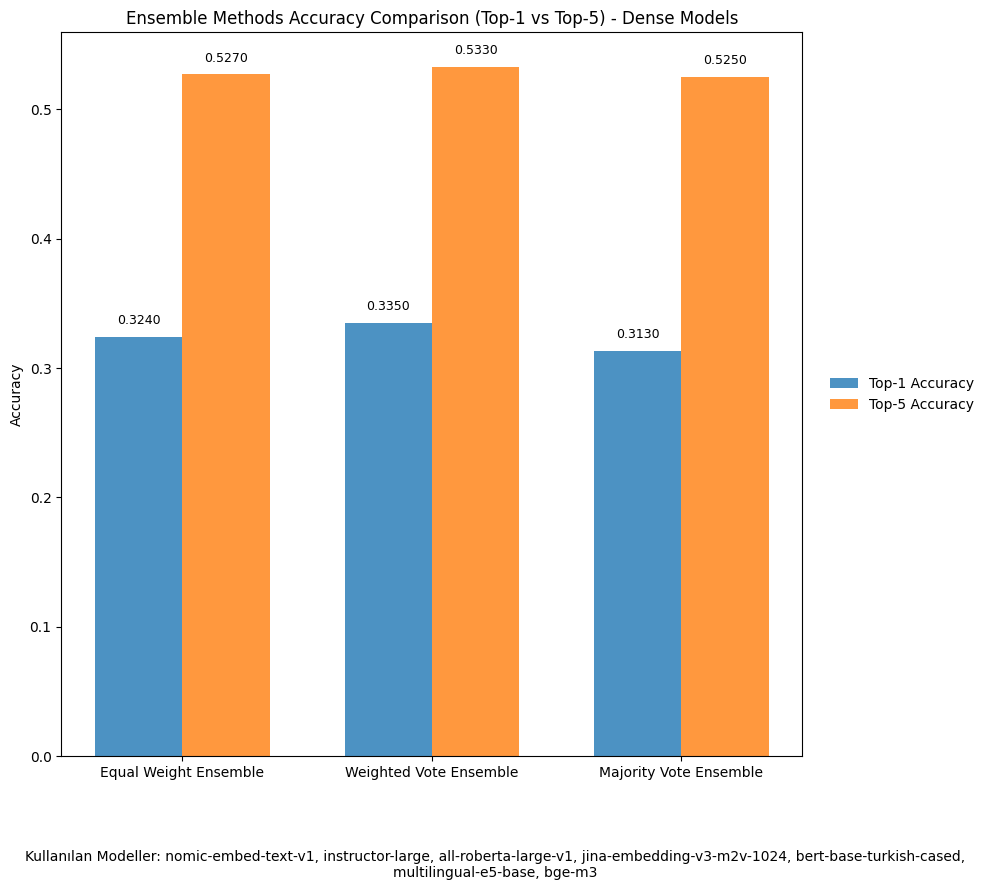

In [ ]:
# Ensemble yöntemleri ve doğruluk sonuçları
ensemble_methods = ["Equal Weight Ensemble", "Weighted Vote Ensemble", "Majority Vote Ensemble"]
top_1_accuracies = [
    equal_weight_results_filtered["top_1_accuracy"],
    weighted_ensemble_results_filtered["top_1_accuracy"],
    majority_ensemble_results_filtered["top_1_accuracy"]
]
top_5_accuracies = [
    equal_weight_results_filtered["top_5_accuracy"],
    weighted_ensemble_results_filtered["top_5_accuracy"],
    majority_ensemble_results_filtered["top_5_accuracy"]
]

# Filtrelenmiş modellerin isimleri
filtered_models = ["nomic-embed-text-v1", "instructor-large", "all-roberta-large-v1",
                       "jina-embedding-v3-m2v-1024", "bert-base-turkish-cased",
                       "multilingual-e5-base", "bge-m3"]

# Çubuk grafik
x = np.arange(len(ensemble_methods))  # Ensemble yöntemleri için x ekseni

plt.figure(figsize=(10, 8))  # Grafik boyutları
bar_width = 0.35  # Çubuk genişliği
plt.bar(x - bar_width / 2, top_1_accuracies, width=bar_width, label="Top-1 Accuracy", alpha=0.8)
plt.bar(x + bar_width / 2, top_5_accuracies, width=bar_width, label="Top-5 Accuracy", alpha=0.8)

# Grafik detayları
plt.xticks(x, ensemble_methods, rotation=0, ha='center')
plt.ylabel("Accuracy")
plt.title("Ensemble Methods Accuracy Comparison (Top-1 vs Top-5) - Dense Models")

# Legend'i sağ tarafa taşıma
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

# Alt kısma kullanılan modelleri yazdırma
model_text = "Kullanılan Modeller: " + ", ".join(filtered_models)
plt.figtext(0.5, -0.1, model_text, wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()

# Skorları çubukların üzerine yazma
for i, v in enumerate(top_1_accuracies):
    plt.text(x[i] - bar_width / 2, v + 0.01, f"{v:.4f}", ha='center', fontsize=9)

for i, v in enumerate(top_5_accuracies):
    plt.text(x[i] + bar_width / 2, v + 0.01, f"{v:.4f}", ha='center', fontsize=9)

plt.show()

In [ ]:
# Kullanılacak dense modelleri filtrele
filtered_model_results = {
    model_name: model_results[model_name]
    for model_name in ["tfidf_word", "tfidf_bert", "bm25_word", "bm25_bert"]
}

# Equal weight ensemble sonuçlarını hesapla (sadece WM modellerle)
equal_weight_results_filtered = equal_weight_ensemble(filtered_model_results, selected_correct_indices, top_k=5)
print(f"Equal Weight Ensemble (WM Models) - Top-1 Accuracy: {equal_weight_results_filtered['top_1_accuracy']:.4f}")
print(f"Equal Weight Ensemble (WM Models) - Top-5 Accuracy: {equal_weight_results_filtered['top_5_accuracy']:.4f}")

# Weighted vote ensemble sonuçlarını hesapla (sadece WM modellerle)
weighted_ensemble_results_filtered = weighted_vote_ensemble(filtered_model_results, selected_correct_indices, top_k=5)
print(f"Weighted Vote Ensemble (WM Models) - Top-1 Accuracy: {weighted_ensemble_results_filtered['top_1_accuracy']:.4f}")
print(f"Weighted Vote Ensemble (WM Models) - Top-5 Accuracy: {weighted_ensemble_results_filtered['top_5_accuracy']:.4f}")

# Majority vote ensemble sonuçlarını hesapla (sadece WM modellerle)
majority_ensemble_results_filtered = majority_vote_ensemble(filtered_model_results, selected_correct_indices, top_k=5)
print(f"Majority Vote Ensemble (WM Models) - Top-1 Accuracy: {majority_ensemble_results_filtered['top_1_accuracy']:.4f}")
print(f"Majority Vote Ensemble (WM Models) - Top-5 Accuracy: {majority_ensemble_results_filtered['top_5_accuracy']:.4f}")

Equal Weight Ensemble (WM Models) - Top-1 Accuracy: 0.2880
Equal Weight Ensemble (WM Models) - Top-5 Accuracy: 0.4980
Top-1 ağırlıkları: {'tfidf_word': 0.25918944392082943, 'tfidf_bert': 0.26013195098963243, 'bm25_word': 0.2064090480678605, 'bm25_bert': 0.27426955702167766}
Top-5 ağırlıkları: {'tfidf_word': 0.2501368363437329, 'tfidf_bert': 0.25944170771756975, 'bm25_word': 0.22003284072249588, 'bm25_bert': 0.2703886152162014}
Weighted Vote Ensemble (WM Models) - Top-1 Accuracy: 0.2890
Weighted Vote Ensemble (WM Models) - Top-5 Accuracy: 0.5000
Majority Vote Ensemble (WM Models) - Top-1 Accuracy: 0.2720
Majority Vote Ensemble (WM Models) - Top-5 Accuracy: 0.4880


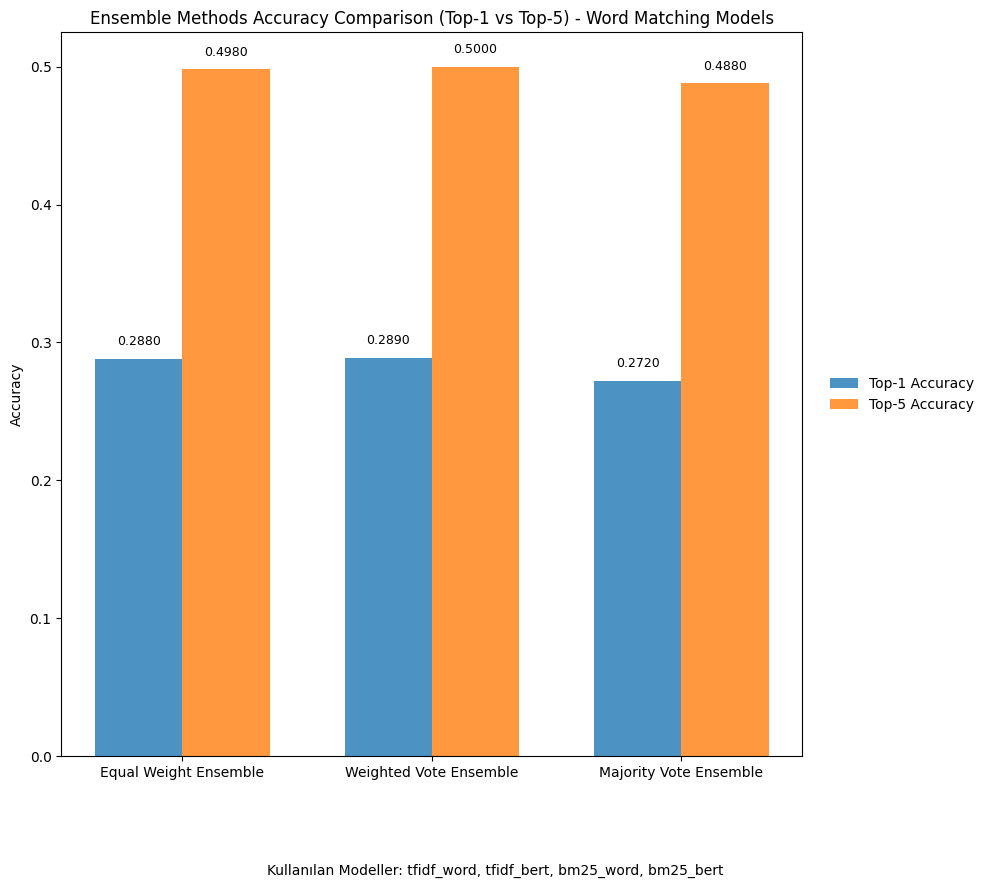

In [ ]:
# Ensemble yöntemleri ve doğruluk sonuçları
ensemble_methods = ["Equal Weight Ensemble", "Weighted Vote Ensemble", "Majority Vote Ensemble"]
top_1_accuracies = [
    equal_weight_results_filtered["top_1_accuracy"],
    weighted_ensemble_results_filtered["top_1_accuracy"],
    majority_ensemble_results_filtered["top_1_accuracy"]
]
top_5_accuracies = [
    equal_weight_results_filtered["top_5_accuracy"],
    weighted_ensemble_results_filtered["top_5_accuracy"],
    majority_ensemble_results_filtered["top_5_accuracy"]
]

# Filtrelenmiş modellerin isimleri
filtered_models = ["tfidf_word", "tfidf_bert", "bm25_word", "bm25_bert"]

# Çubuk grafik
x = np.arange(len(ensemble_methods))  # Ensemble yöntemleri için x ekseni

plt.figure(figsize=(10, 8))  # Grafik boyutları
bar_width = 0.35  # Çubuk genişliği
plt.bar(x - bar_width / 2, top_1_accuracies, width=bar_width, label="Top-1 Accuracy", alpha=0.8)
plt.bar(x + bar_width / 2, top_5_accuracies, width=bar_width, label="Top-5 Accuracy", alpha=0.8)

# Grafik detayları
plt.xticks(x, ensemble_methods, rotation=0, ha='center')
plt.ylabel("Accuracy")
plt.title("Ensemble Methods Accuracy Comparison (Top-1 vs Top-5) - Word Matching Models")

# Legend'i sağ tarafa taşıma
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

# Alt kısma kullanılan modelleri yazdırma
model_text = "Kullanılan Modeller: " + ", ".join(filtered_models)
plt.figtext(0.5, -0.1, model_text, wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()

# Skorları çubukların üzerine yazma
for i, v in enumerate(top_1_accuracies):
    plt.text(x[i] - bar_width / 2, v + 0.01, f"{v:.4f}", ha='center', fontsize=9)

for i, v in enumerate(top_5_accuracies):
    plt.text(x[i] + bar_width / 2, v + 0.01, f"{v:.4f}", ha='center', fontsize=9)

plt.show()